# Fundamentals of Machine Learning - 2022
## Report 2 - Classifying with convnets
Pablo Chehade  
Última modificación: 25/09/2022


### Introducción

Hay que construir 2 modelos: uno con ML clásico y otro con NN. El problema es uno de clasificación de imágenes (supervisado)

¿Cómo se evalúa el error? Qué parámetros se usarán?

TENGO QUE PONERME A RELEER LAS CLASES DE ERROR (LA ÚLTIMA PARTE) Y DE K-MEANS. Lo voy a necesitar


### 

In [1]:
#Importo librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score

### Análisis Exploratorio de los Datos

#### Cargo los datos

In [15]:
import pickle
archivo = "datasets/faces_dict.p"
datos = pickle.load(open(archivo, 'rb'))

# infile = open(filename,'rb')
# new_dict = pickle.load(infile)
# infile.close()

#### Ver datos
Hay class imbalance?

In [65]:
print("Labels del diccionario datos: ", datos.keys())
print("Tamaño de cada label: ")
print("data: ", len(datos['data']), ", con elementos de tamaño ", len(datos['data'][0]))
print("images: ", len(datos['images']), ", con elementos de tamaño ", len(datos['images'][0]), "cada elemento de tamaño", len(datos['images'][0][0]))
print("target: ", len(datos['target']))

#Veamos cuántos elementos distintos hay en target
print(np.bincount(datos['target']))


Labels del diccionario datos:  dict_keys(['data', 'images', 'target'])
Tamaño de cada label: 
data:  400 , con elementos de tamaño  4096
images:  400 , con elementos de tamaño  64 cada elemento de tamaño 64
target:  400
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


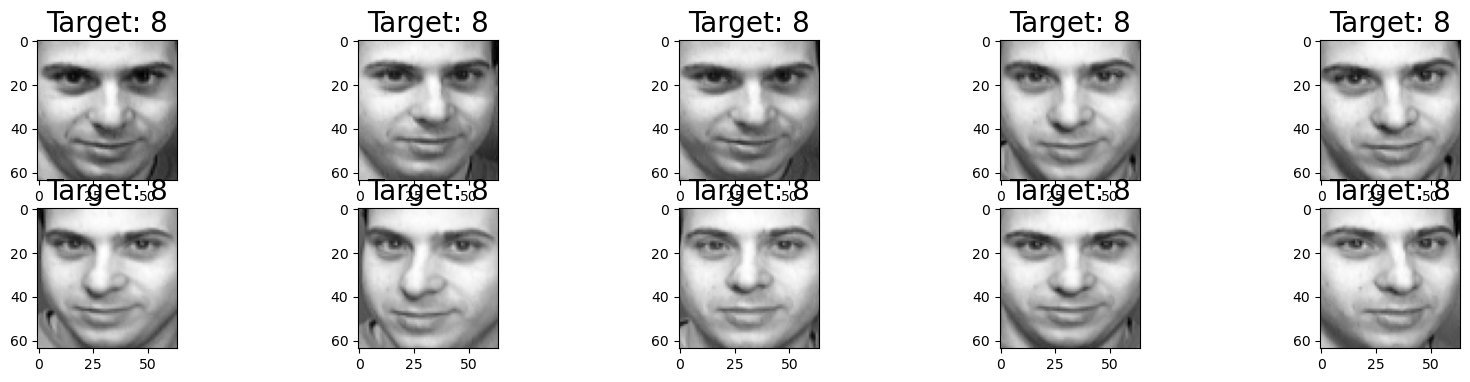

In [76]:
#Grafico algunos elementos de 'data'
#Se grafican de a 10 elementos accedidos mediante el índice k.

plt.figure(figsize=(20,4))
grid_rows = 2 #nro de filas en el grid de imágenes
grid_cols = 5 #nro de columnas en el grid de imágenes
grid_images = grid_rows*grid_cols #nro de imágenes a graficar
k = 8 #índice

for index, (image, label) in enumerate(zip(datos['data'][grid_images*k:grid_images*(k+1)], datos['target'][grid_images*k:grid_images*(k+1)])):
    plt.subplot(grid_rows, grid_cols, index + 1)
    plt.imshow(image.reshape(64,64), cmap=plt.cm.gray)
    plt.title('Target: %i' % label, fontsize = 20)


##### Observaciones
El .pickle es un diccionario con 3 labels: 'data', 'images' y 'target'
* En 'data' hay 400 elementos que representan las imágenes como arrays de 4096 (64x64). Se observa que las imágenes se encuentran ordenadas. 10 elementos consecutivos corresponen a la misma persona (mismo target)
* En 'images' hay 400 elementos que representan cada uno una matriz de 64x64 (imagen)
* En 'target' están los tags de las personas


### MODELO 1: Random Forest

¿Por qué este modelo en particular? Porque el entrenamiento es relativamente rápido.  
No se usará el modelo directamente sobre las imágenes debido a la poca cantidad de datos (400) y a la gran cantidad de variables (64x64). Si se usara se obtendría un modelo muy malo a priori. Es por esto que se empleará inicialmente k-means para hacer una reducción de dimensionalidad y luego entrenar el modelo de clasificación sobre el set reducido.


RECOMENDACIÓN: use K-Means as a dimensionality reduction tool and train a classifier on the
reduced set (i.e., using the distances to the centroids).

#### Separo entre train y test

El objetivo del modelo es, dada una foto de una persona que ya se encuentra en el dataset, ser capaz de predecir a qué target pertenece (quién es). Entonces, podemos elegir de forma inteligente el set de train. Si lo hacemos aleatoriamente podríamos caer en un situación en la que haya muy pocas imágenes de una persona en el set de train y gran parte en el test o, aún peor, que todas las imágenes de una persona se encuentren en el test! Para evitar esto se puede hacer "stratified samping"

BUSCAR QUÉ ES stratified sampling 

En base a esto, el set de test no será elegido aleatoriamente sobre todos los datos, sino sobre los datos de cada target. Por ejemplo, si el set de test cuenta con el 20% de los datos, esto significa que de cada persona elegiremos aleatoriamente 2 imágenes para el set de test.

In [77]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(datos['data'], datos['target']):
    train_predictors, test_predictors = datos['data'][train_index], datos['data'][test_index]
    train_target, test_target = datos['target'][train_index], datos['target'][test_index]

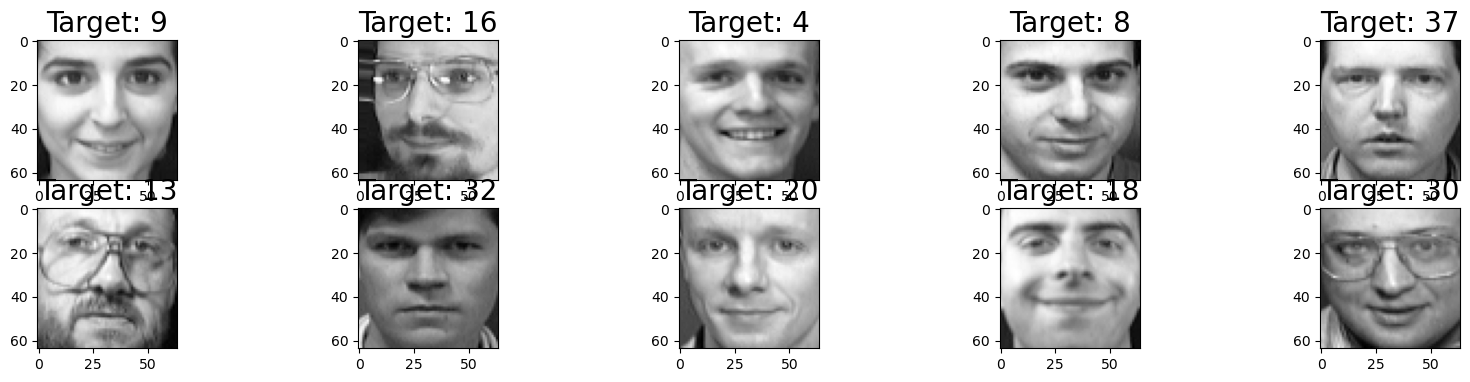

In [78]:
#Verificación
plt.figure(figsize=(20,4))
grid_rows = 2 #nro de filas en el grid de imágenes
grid_cols = 5 #nro de columnas en el grid de imágenes
grid_images = grid_rows*grid_cols #nro de imágenes a graficar
k = 5 #índice

for index, (image, label) in enumerate(zip(test_predictors[grid_images*k:grid_images*(k+1)], test_target[grid_images*k:grid_images*(k+1)])):
    plt.subplot(grid_rows, grid_cols, index + 1)
    plt.imshow(image.reshape(64,64), cmap=plt.cm.gray)
    plt.title('Target: %i' % label, fontsize = 20)


In [79]:
#Veamos si efectivamente hay 2 elementos de cada clase en el conjunto de test
print(np.bincount(test_target))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


### Data augmentation?

Data augmentation artificially increases the size of the training set by generating
many realistic variants of each training instance. This reduces overfitting, making this
a regularization technique. The generated instances should be as realistic as possible: ideally, given an image from the augmented training set, a human should not be able
to tell whether it was augmented or not. Moreover, simply adding white noise will not
help; the modifications should be learnable (white noise is not).

Se explica bien en
https://neptune.ai/blog/data-augmentation-in-python
Existen librerías en Python para hacer este procedimiento casi automáticamente. Están todas explicadas en ese link

Podría usar una IA para rotar caras?

#### K-MEANS

64

In [125]:
from sklearn.cluster import KMeans
k = 50 #sé a priori la cantidad de clusters que esperaría ver. Podría poner un valor más alto pero considerando que por cada cluster habrá una nueva clase para el modelo de clasificación, mejor ser conservador. Técnicamente k es un hiperparámetro que habría que variar en el gridsearch.
kmeans = KMeans(n_clusters=k, random_state=42)
train_kdist = kmeans.fit_transform(train_predictors) #Construye los clusters y calcula las distancias a cada cluster

test_kdist = kmeans.transform(test_predictors) #Calcula la distancia entre una imagen de test_predictors y todos los clusters anteriores (no hay un entrenamiento con estos nuevos datos). Esto será importante para evaluar al final el error del modelo

In [102]:
print(test_kdist[0])

[11.023374   9.495662  11.555289  13.345615  10.708946   9.5363865
 10.740454   6.053207   7.9195476 10.041745  12.798966   8.584623
  8.123885   9.528347  10.897272 ]


#### Modelo simple inicial

Creo un modelo con los parámetros por default salvo (...). Por default vale (...) e implica rápidamente overfitting

* En el práctico anterior: Con los parámetros por default el modelo tiene error nulo (accuracy de 100%) está overfitteando. Cambiando el parámetro max_depth a 10, el modelo tiene un error asociado y por lo tanto no overfittea (al menos no tanto como antes). Por default la variable max_depth está en None, es decir, los nodos se expanden hasta que las leaves sean puras, de ahí el overfitting quizás.

In [126]:
RFtrain_predictors = train_kdist.copy()
RFtrain_target = train_target.copy()
RFtest_predictors = test_kdist.copy()
RFtest_target = test_target.copy()

In [127]:
from sklearn.ensemble import RandomForestClassifier
#Creo el modelo
RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 100, max_depth = 10, min_samples_split = 2, min_samples_leaf = 1)
#Lo entreno
RFmodel.fit(RFtrain_predictors, RFtrain_target)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

##### Cross Validation

Calculo el error de validación del modelo. Uso cv=5 para que el programa corra rápido

In [99]:
from sklearn.model_selection import cross_val_score

### definamos una función para presentar los resultados 
def display_scores(scores):
    print("Scores:", scores) #Score de cada partición
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [145]:
scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=8) #cv es la cantidad de particiones
display_scores(scores)


Scores: [0.825 0.85  0.875 0.825 0.925 0.85  0.825 0.8  ]
Mean: 0.846875
Standard deviation: 0.03630921887069455


In [124]:
print(len(RFtrain_predictors[0]))

4096


PELADO: 0.81875  
K = 10: 0.5875
K = 15: 0.65
K = 20: 0.66875

RESULTA QUE EL MODELO SIN K-MEANS TIENE MEJOR DESEMPEÑO QUE EL DE K-MEANS. Esto no tiene sentido. Formalmente, tengo que optar por trabajar con RF
Podría ocurrir que para una config específica de RF, Kmeans tenga un mejor resultado pero decido no hacer ese análisis

In [147]:
#Hago copia de los datos originales sin k-means
RFtrain_predictors = train_predictors.copy()
RFtrain_target = train_target.copy()
RFtest_predictors = test_predictors.copy()
RFtest_target = test_target.copy()

In [ ]:
# #Veamos cómo se comporta el error de train vs error de validación con la complejidad del modelo. Para el caso de K-means usaremos como "complejidad" al parámetro k

# k_array = np.arange(2,10,1)
# train_error_array = np.zeros(len(k_array))
# val_error_array = np.zeros(len(k_array))

# for i in np.arange(len(k_array)):
#     k = k_array[i]

#     #Clustering
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     train_kdist = kmeans.fit_transform(train_predictors)

#     RFtrain_predictors = train_kdist.copy()
#     RFtrain_target = train_target.copy()

#     #Creo el modelo
#     RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 100, max_depth = 10, min_samples_split = 2, min_samples_leaf = 1)
#     #Lo entreno
#     RFmodel.fit(train_predictors, train_target)
#     scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones

#     train_error_array[i] = 2 #SE OBTIENE AL HACER GRID SEARCH 
#     val_error_array[i] = scores.mean()
    


#### Grid Search

En el práctico anterior se discutió este modelo con detalle, junto a los parámetros que se pueden variar. En este caso se decidió variar:
1. n_estimators: nro de trees en el forest  
* Default: 100  
* Variación: 10 a 200
2. criterion: función para medir el error en el split
* Default: "gini"  
* Variación: ["gini", "entropy", "log_loss"]  
3. max_depth: máxima depth en el tree
* Default = None, es decir, los nodos se expanden hasta que todas las leaves sean puras  
* Variación: 1 a 100
4. min_samples_split: nro minimo de samples necesarios para hacer un split en un nodo interno
* Default: 2
* Variación: 1 a 10
5. min_samples_leaf: nro mínimo de samples necesario para estar en un leaf node.
* Default: 1
* Variación: 1 a 20
6. max_features: nro de atributos considerados al buscar el mejor split. Sea p la cantidad total de variables.
* Default: sqrt(p)
* Variación: ["sqrt", "log2"]

In [212]:
#Tengo que poner que me devuelva el error de test para cada entrenamiento del modelo

from sklearn.model_selection import GridSearchCV

#Defino los parámetros a variar:
n_stimators_list = [1,2,4,10,20,80,160]
criterion_list = ["gini"]  
max_depth_list = [1,2,4,10,20,60]
min_samples_split_list = [1,2,4,8]
min_samples_leaf_list = [1,2,4,8]
max_features_list = ["sqrt", "log2"]


param_grid = [
    {'n_estimators': n_stimators_list, 'criterion': criterion_list,  'max_depth': max_depth_list, 'min_samples_split':min_samples_split_list, 'min_samples_leaf':min_samples_leaf_list, 'max_features': max_features_list, 'oob_score':[True]},
  ]

# param_grid = [
#   {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
# ]

#Defino el modelo
RFmodel_GS = RandomForestClassifier(n_jobs = -1, random_state=42, oob_score = True)

grid_search = GridSearchCV(RFmodel_GS, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 3); #verbose muestra el progreso a medida que se hace el gridsearch. A mayor valor, más info da. El máximo es 3. Es útil cuando tengo que hacer corridas largas.
grid_search.fit(RFtrain_predictors, RFtrain_target)


Fitting 5 folds for each of 4032 candidates, totalling 20160 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   3.8s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   3.4s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   3.4s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   3.3s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   3.4s


KeyboardInterrupt: 

In [193]:
print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
print("val_score, train_score, params")
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    print(val_score, train_score, params)

Los mejores parámetros son: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
El score de cada combinación de hiperparámetros es:
val_error, train_error, params
0.24375 0.446875 {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.546875 0.8015625 {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.775 0.96796875 {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.8625 0.99921875 {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.90625 1.0 {'criterion': 'entropy', 'max_depth': 5, 'max_

##### ¿Cómo depende el error de train y el error de validación con la complejidad del modelo?

Para evaluar esto es necesario definir la "complejidad del modelo"

Estaría bueno hacer una gráfica de error de test y error de validación en función de la complejidad, donde complejidad hace referencia realmente a cualquier parámetro que se pueda variar. Entonces, para cada parámetro haría un promedio de los resultados obtenidos con ese parámetro constante y los demás variables

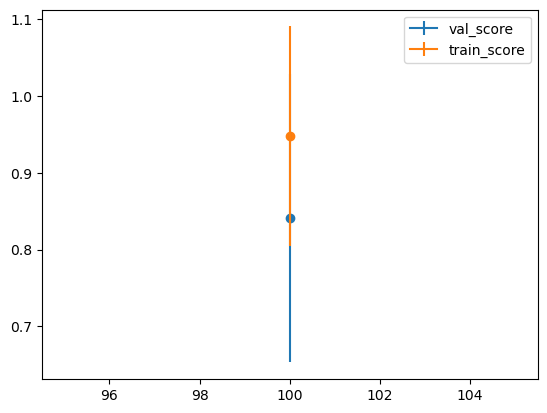

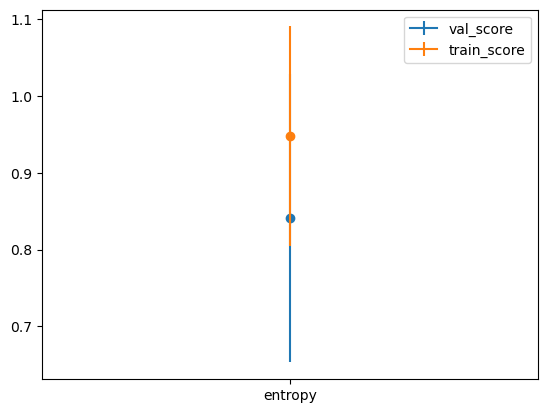

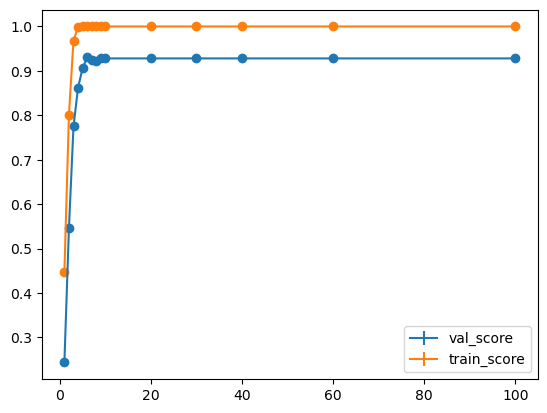

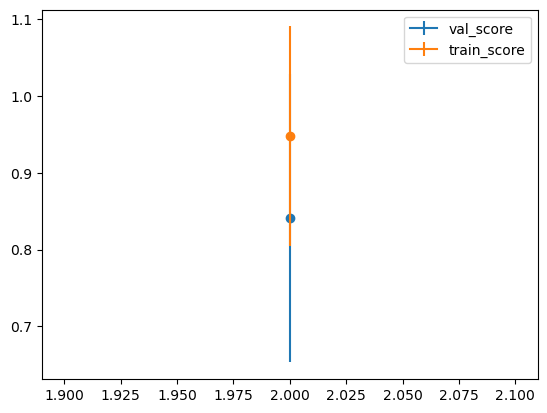

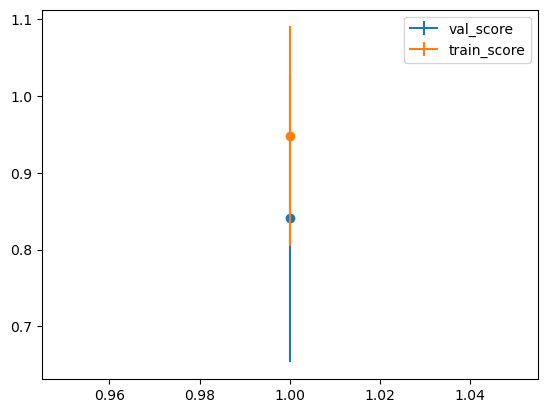

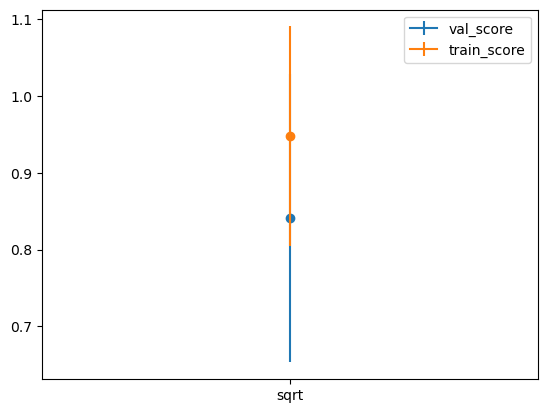

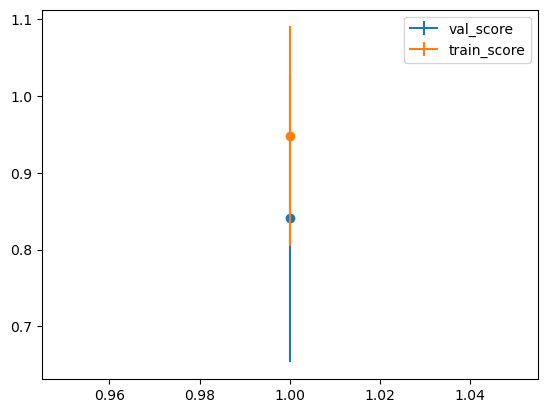

In [200]:
#Calculo la cantidad de configuraciones consideradas
n_configs = 0
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    n_configs = n_configs + 1

#key = 'max_depth'
for key in param_grid[0].keys():
    x_axis = param_grid[0][key]
    n_elems = int(n_configs/len(x_axis)) #nro de configuraciones que tienen el mismo valor de key. Es un entero
    val_axis = np.zeros([len(x_axis),n_elems])
    val_mean_axis = np.zeros(len(x_axis))
    val_std_axis = np.zeros(len(x_axis))
    train_axis = np.zeros([len(x_axis),n_elems])
    train_mean_axis = np.zeros(len(x_axis))
    train_std_axis = np.zeros(len(x_axis))

    #Recorro todas las configuraciones de parámetros
    for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
        #Recorro sobre las posibles configuraciones de key
        for i in range(len(x_axis)):
            #Si algún parámetro coincide con determinada configuración de key, lo tengo que considerar
            if(params[key] == x_axis[i]):
                #Recorro todos los valores ya guardados para cada configuración. Si alguno no es cero, escribo sobre ese punto y salgo del for.
                for j in range(n_elems):
                    if val_axis[i,j] == 0:
                        val_axis[i,j] = val_score
                        break
                for j in range(n_elems):
                    if train_axis[i,j] == 0:
                        train_axis[i,j] = train_score
                        break

    #Calculo el promedio y la desviación estándar

    for i in range(len(x_axis)):
        val_mean_axis[i] = np.mean(val_axis[i,:])
        val_std_axis[i] = np.std(val_axis[i,:])
        train_mean_axis[i] = np.mean(train_axis[i,:])
        train_std_axis[i] = np.std(train_axis[i,:])


    plt.errorbar(x_axis, val_mean_axis, val_std_axis, label = 'val_score')
    plt.scatter(x_axis, val_mean_axis)
    plt.errorbar(x_axis, train_mean_axis, train_std_axis, label = 'train_score')
    plt.scatter(x_axis, train_mean_axis)
    plt.legend()
    plt.show()


##### Observaciones
El modelo overiftea SIEMPRE. Logra un 

#### Feature Importances
No se puede aplicar en este caso porque las features son los píxeles! Quizás halla "pixeles" más importantes que otros pero no lo sé

#### Best Random Forest model

In [ ]:
#El mejor modelo de Random Forest es
# RFmodel_score = cross_val_score(grid_search.best_estimator_, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5)
# display_scores(RFmodel_score)
RF_best_params = grid_search.best_estimator_.get_params()
RFmodel = RandomForestClassifier()
RFmodel.set_params(**RF_best_params);
RFmodel.fit(RFtrain_predictors, RFtrain_target)

### MODELO 2: DL

In [215]:
#Importo librerías
import tensorflow as tf
import keras

#### Separo entre Train y Test
Cargo datos. Para Random Forest bastó usar la imagen como input un array de 4096 elementos. Para redes convolucionales se emplea la imagen como una matriz de 64x64 con valores entre 0 y 1. Los datos dados en la sección 'images' del diccionario 'datos' ya se encuentran entre 0 y 1. Además, el output no puede tener el mismo formato que antes, hay que fabricar por cada categoría una columna y asignarle un 1 a la categoría que pertenezca determinada imagen, es decir, hay que hacer one hot encoding.

In [312]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(datos['images'], datos['target']):
    train_predictors, test_predictors = datos['images'][train_index], datos['images'][test_index]
    train_target, test_target = datos['target'][train_index], datos['target'][test_index]

from keras.utils.np_utils import to_categorical
DLtrain_predictors = train_predictors.copy()
DLtrain_target = to_categorical(train_target, 40) #one-hot-encoding
DLtest_predictors = test_predictors.copy()
DLtest_target = to_categorical(train_target, 40) #one-hot-encoding


#### Modelo simple inicial

In [326]:
from functools import partial

#Defino algunos parámetros fijos de las layers convolucionales para no repetirlos continuamente:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

#Construyo la red neuronal
n_clases = 40

DLmodel = keras.models.Sequential([
    keras.layers.MaxPooling2D(pool_size=2, input_shape=[64, 64, 1]),
    DefaultConv2D(filters=10, kernel_size=7),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=20),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=40),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=20, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=n_clases, activation='softmax'),
])


# model = keras.models.Sequential([
#     DefaultConv2D(filters=64, kernel_size=7, input_shape=[64, 64, 1]),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=128),
#     DefaultConv2D(filters=128),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=256),
#     DefaultConv2D(filters=256),
#     keras.layers.MaxPooling2D(pool_size=2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units=128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=n_clases, activation='softmax'),
# ])

#Agrego optimizador, función de loss (Cross Entropy, sugerida en el Gerón para Multiclass Classification) y métricas de error
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = tf.keras.metrics.SparseCategoricalAccuracy())
DLmodel.compile(optimizer="adam",
              loss='categorical_crossentropy', metrics=['accuracy'])  
#Si uso CategoricalCrossEntropy el modelo espera que el target esté como one-hot encoding. Lo mismo ocurre con la métrica.

In [327]:
DLmodel.fit(DLtrain_predictors, DLtrain_target, epochs=100, verbose = 2, validation_split = 0.2)
#el parámetro verbose = 2 muestra el progreso de cada epoch
#Se puede agregar " validation_data=(test_predictors, test_target)"

Epoch 1/100
8/8 - 1s - loss: 3.6894 - accuracy: 0.0234 - val_loss: 3.6939 - val_accuracy: 0.0312 - 1s/epoch - 177ms/step
Epoch 2/100
8/8 - 0s - loss: 3.6861 - accuracy: 0.0312 - val_loss: 3.6925 - val_accuracy: 0.0312 - 353ms/epoch - 44ms/step
Epoch 3/100
8/8 - 0s - loss: 3.6861 - accuracy: 0.0156 - val_loss: 3.6959 - val_accuracy: 0.0312 - 352ms/epoch - 44ms/step
Epoch 4/100
8/8 - 0s - loss: 3.6773 - accuracy: 0.0391 - val_loss: 3.6984 - val_accuracy: 0.0312 - 391ms/epoch - 49ms/step
Epoch 5/100
8/8 - 0s - loss: 3.6769 - accuracy: 0.0273 - val_loss: 3.7017 - val_accuracy: 0.0312 - 416ms/epoch - 52ms/step
Epoch 6/100
8/8 - 0s - loss: 3.6803 - accuracy: 0.0391 - val_loss: 3.6905 - val_accuracy: 0.0312 - 373ms/epoch - 47ms/step
Epoch 7/100
8/8 - 0s - loss: 3.6681 - accuracy: 0.0273 - val_loss: 3.6894 - val_accuracy: 0.0312 - 398ms/epoch - 50ms/step
Epoch 8/100
8/8 - 0s - loss: 3.6631 - accuracy: 0.0469 - val_loss: 3.6854 - val_accuracy: 0.0469 - 469ms/epoch - 59ms/step
Epoch 9/100
8/8 - 

In [324]:
#Evaluamos el modelo
DLmodel.compute_metrics(DLtrain_predictors, DLtrain_target, DLmodel.predict(DLtrain_predictors), sample_weight=None)
#type(model.predict(train_predictors))

10/10 [==============================] - 0s 5ms/step


AttributeError: 'tuple' object has no attribute 'rank'

##### Cross Validation

No se puede usar la función CrossValidation de Scikit-learn. keras permite hacer validación sobre una parte del set de train pero según encontré no se puede hacer cross validation con varios splits. Por lo tanto, es necesario programarlo a mano

In [359]:
from sklearn.model_selection import StratifiedKFold
cv_splits = 5
verbose_ = 0 #indica si se muestra el progreso de cada epoch sobre cada entrenamiento o no
cv_epochs = 1000 #nro de epochs por cada entrenamiento


#Crear modelo
DLmodel = keras.models.Sequential([
keras.layers.MaxPooling2D(pool_size=2, input_shape=[64, 64, 1]),
DefaultConv2D(filters=10, kernel_size=7),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=20),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=40),
keras.layers.MaxPooling2D(pool_size=2),
keras.layers.Flatten(), #Convierte la matriz en un vector. Esto es necesario porque la capa densa no acepta matrices, sino arrays.
keras.layers.Dense(units=20, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=n_clases, activation='softmax'),])

#Compilar modelo
DLmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])  

def DLCrossValidation(DLmodel, cv_splits, cv_epochs, verbose_, DLtrain_predictors, DLtrain_target, train_target):
    #Hace cross-validation sobre el modelo DLmodel, con cv_splits splits y cv_epochs epochs por cada split.
    #Retorna el accuracy de validación y de train de cada split.

    kfold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    cv_valid_score = np.zeros(cv_splits)
    cv_train_score = np.zeros(cv_splits)

    contador = 0
    for train, test in kfold.split(DLtrain_predictors, train_target): #notese train_target no es DLtrain_target
        #Reporto qué modelo se está entrenando
        print("Entrenando modelo ", contador)
        contador = contador + 1

        #Fitear modelo: según entiendo estoy volviendo a fitear el modelo como si el anterior no existiera. Esto está "fundamentado" en https://stackoverflow.com/questions/49841324/what-does-calling-fit-multiple-times-on-the-same-model-do
        DLmodel.fit(DLtrain_predictors[train], DLtrain_target[train,:], epochs=cv_epochs, verbose = verbose_)
        #Evaluar modelo:
        scores_val = DLmodel.evaluate(DLtrain_predictors[test], DLtrain_target[test]) #scores es un array con el loss y el accuracy
        scores_train = DLmodel.evaluate(DLtrain_predictors[train], DLtrain_target[train]) #scores es un array con el loss y el accuracy
        #Guardar score:
        cv_valid_score[contador-1] = scores_val[1]
        cv_train_score[contador-1] = scores_train[1]
    return cv_valid_score, cv_train_score

cv_valid_score, cv_train_score = DLCrossValidation(DLmodel, cv_splits, cv_epochs, verbose_, DLtrain_predictors, DLtrain_target, train_target)


Entrenando modelo  0


KeyboardInterrupt: 

In [ ]:
#Se obtuvo:

In [358]:
#Calculo media de accuracy y desviación estándar
print("CV-validation-accuracy: ","%.2f +/- %.2f" % (np.mean(cv_valid_score), np.std(cv_valid_score)))
print("CV-train-accuracy: ","%.2f +/- %.2f" % (np.mean(cv_train_score), np.std(cv_train_score)))

CV-accuracy:  0.90 +/- 0.08


In [ ]:
#Se obtuvo:

#### Grid Search

¿Qué parámetros hay presentes para variar?
* Parámetros de contrucción de la red (arquitectura). Aquí se encuentran, por ejemplo, la cantidad de layers convolucionales y pooling y su ordenamiento, la cantidad de mapas de activación en cada layer convolucional, el tipo de pooling (max, mean, etc....), la cantidad de layers densas al final de la red y su función de activación asociada, entre otras. Se decidió optar por una arquitectura fija, maxpooling (recomendación en Gerón) y dos capas densas al final con "relu" como función de activación (recomendación en Gerón). En cuanto a la arquitectura, se comenzará con una layer maxpooling de modo de disminuir el tamaño de la imagen de 64x64 a 32x32 y así poder facilitar la ejecución del modelo, para luego continuar con series de layers convolucional, pooling, convolucional, .... y así sucesivamente en una cantidad fija. Además, la cantidad de mapas de activación de cada layer convolucional será variable pero no arbitrariamente. Todas estarán relacionadas por un único parámetro: tal cantidad en la primer capa.

También sobre las layers convs: tamaño del kernel, tamaño del salto (...), función de activación, padding, dropout
* Parámetros del modelo
Se podría variar la función de loss, la métrica, loss weights (pesos de cada output en el cálculo de la loss)
Existen otros atributos pero están más relacionados con la performance del modelo
Se decidió variar el tamaño del kernel de las layers intermedias, la primera va a tener siempre 10. Se variará entre 3, 5 y 7. NO SE HARÁ ESTO POR CUESTIONES DE CÁLCULO
Se decidió variar la cantidad de mapas de activación
No se varía ningún parámetro que no sea de la arquitectura
epochs tmb se puede variar. Yo lo voy a mantener en 1000
Hacer padding o no

Explicar por qué hice el grid search a mano

In [360]:

def DLCreate_model(n_mp):
    #Crea el DLmodel considerando como inputs los parámetros que se van a variar en el gridsearch
    #n_mp: nro de mapas de activación de la primer capa convolucional. Los demás se calculan en función de este.

    #Defino algunos parámetros fijos de las layers convolucionales para no repetirlos continuamente
    DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

    #Creo el modelo
    DLmodel = keras.models.Sequential([
    keras.layers.MaxPooling2D(pool_size=2, input_shape=[64, 64, 1]),
    DefaultConv2D(filters=n_mp, kernel_size=10),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=2*n_mp),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=4*n_mp),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(), #Convierte la matriz en un vector. Esto es necesario porque la capa densa no acepta matrices, sino arrays.
    keras.layers.Dense(units=2*n_mp, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=n_clases, activation='softmax'),])

    #Compilar modelo
    DLmodel.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return DLmodel


In [364]:
n_mp_array = [5,10,20]
train_score = np.zeros(len(n_mp_array))
train_stdscore = np.zeros(len(n_mp_array))
valid_score = np.zeros(len(n_mp_array))
valid_stdscore = np.zeros(len(n_mp_array))


for n_mp in n_mp_array:
    DLmodel = DLCreate_model(n_mp)
    cv_valid_score, cv_train_score = DLCrossValidation(DLmodel, cv_splits, cv_epochs, verbose_, DLtrain_predictors, DLtrain_target, train_target)
    print("cv_valid_score: ", cv_valid_score)
    print("cv_train_score: ", cv_train_score)

    #Calculo media de accuracy y desviación estándar de train y valid
    train_score[n_mp_array.index(n_mp)] = np.mean(cv_train_score)
    train_stdscore[n_mp_array.index(n_mp)] = np.std(cv_train_score)
    valid_score[n_mp_array.index(n_mp)] = np.mean(cv_valid_score)
    valid_stdscore[n_mp_array.index(n_mp)] = np.std(cv_valid_score)


Entrenando modelo  0


KeyboardInterrupt: 

In [ ]:
#Grafico:
plt.errorbar(n_mp_array, train_score, yerr=train_stdscore, fmt='o', label='train')
plt.errorbar(n_mp_array, valid_score, yerr=valid_stdscore, fmt='o', label='valid')
plt.xlabel('n_mp')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Evaluación de test y exportación del modelo

In [304]:
train_predictions = model.predict(train_predictors)
print(np.max(train_predictions[0]))
print(train_target)
#model.compute_metrics(train_predictors, to_categorical(train_target, 40), train_predictions, sample_weight=None)

10/10 [==============================] - 0s 7ms/step
0.74051195
[13  5  3 12 10 20 24 35 11 13  1  9 20 37  1 20 35 32 36 33 16 33 19  7
 23 33 10 36 19 13 15 22 34 12  8  0  8 34 32 28 34  6  3 31 21 21 38 13
  8 12 25 34  5 26 33 16  4 37 20 35 20  8  3  6  9 30  4 31 18  0 16  9
 25 37 18 38  1 10 39  5 31 24  7 28 14 32 33 25  3 31 39 32 10 30 18  9
  3  8  1 24 31  7 15 22 39 28  7 16 24 26 20 26 26 39  3 17 16 26 27 29
 30 14 32 38 25 36 38 21 36 34 30 19  2 28  9 29 27 16 13 14 38 24  0 28
 10  4 16 39 38 29 17 25  5  5  9  8  8  1 22 28 29 27 18 10 19 37  0  9
  2 25  0 24 33 26 29 17 26 22 25  1 27 32  4 12 35 10 35 31 35 30 25  3
 23 10 22 29 19  9 24 11  2  8 37 23 23  1 28 30 11  5 14 15 11  4  0 15
 28 16 17 17 36  2  7 14 27 11 22 32 33  2 33 14 18 18 39 13 15 36 34 17
  6 20  6 38  5 11 37 27 13 39 24 12  0 13 29  7  6 12 36 37 22 36 18 15
 23  7 23 19  6 26 11 17 17 32  2 21  4  1  3 30 21  4 21 30 12 34 19 15
 18 35 14 38 21  7  6 27 35  2 15 31 20 31 23 14 23 39 11 22